In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

In [2]:
import seaborn as sns
sns.set_style(
    #style='darkgrid', 
    sns.axes_style("white")
    #rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 80


### Hyperparameters initialisation:

In [3]:
#dimension of the vector beta_i: it has p features we want to learn. Here p=beta_dim
beta_dim =100

In [4]:
#The input x is a scalar and here its dimension is 1
input_dim = 1

In [5]:
#number of rbf centers
num_phi_rbf = 100

#sigma of the radial basis function
phi_rbf_sigma =5.0 

#we need to learn phi using a NN. We assume it has 2 hidden layers, each with 10 neurons
phi_hidden_layer_size = 20

In [6]:
#dimension of the latent variable z that embeds beta
z_dim = 25

In [7]:
# Gives the numbers of betas to learn
num_training_funcs = 1000

In [8]:
#each function f_i is evaluated at K locations. Here K=num_eval_points
#this is the K in the piVAE paper: number of locations where we evaluate each fct/each path:
K = 100

In [9]:
#the encoder and the decoder parts each have 3 layers
encoder_h_dim_1 = 512
encoder_h_dim_2 = 512
encoder_h_dim_3 = 128

decoder_h_dim_1 = 128
decoder_h_dim_2 = 128
decoder_h_dim_3 = 128

In [10]:
# The observation standard deviation the Log Likelihood (observation) model
#obs_sigma = 0.01 

In [11]:
s_lims = [-5., 5.]

In [12]:
def generate_exp_dataset():
    s_append = []
    exponential_samples_at_K_locs = []
    
    for fct_id in range(num_training_funcs):
        s = np.random.uniform(s_lims[0], s_lims[1], size=(K, 1))
        
        A = np.random.uniform(2.0, 3.0)
        B = np.random.uniform(0.2, 0.5)
        
        exp_s = A * np.exp(B * s)
        
        s_append.append(s)
        
        exponential_samples_at_K_locs.append(exp_s)
    return np.array(s_append), np.array(exponential_samples_at_K_locs)       

In [13]:
dataset_exp_s, dataset_exp_x=generate_exp_dataset()
dataset_exp_s.shape

(1000, 100, 1)

In [14]:
dataset_exp_x.shape

(1000, 100, 1)

In [15]:
dataset_exp_x = np.transpose(dataset_exp_x, (0, 2, 1))
dataset_exp_x.shape

(1000, 1, 100)

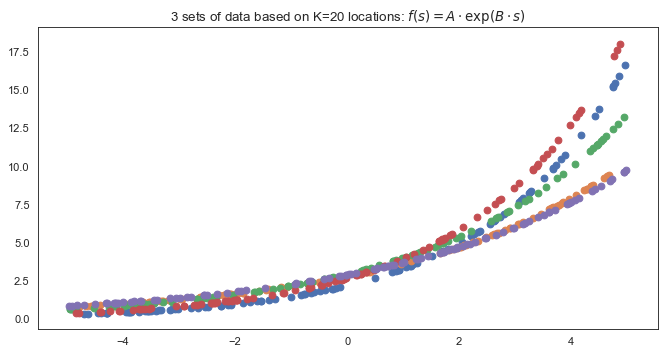

In [16]:
for i in range(5):
    plt.scatter(dataset_exp_s[i,:,0], dataset_exp_x[i,0,:])
plt.title("3 sets of data based on K=20 locations: " r'$f(s)=A \cdot \exp(B\cdot s)$')
plt.show()

In [17]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()                                  
    
        self.phi_rbf_centers = nn.Parameter(torch.tensor(
            np.random.uniform(s_lims[0], s_lims[1],
            size=(num_phi_rbf, input_dim))))
        self.phi_nn_1 = nn.Linear(num_phi_rbf, phi_hidden_layer_size)
        self.phi_nn_2 = nn.Linear(phi_hidden_layer_size, beta_dim)

        self.encoder_nn_1 = nn.Linear(beta_dim, encoder_h_dim_1)
        self.encoder_nn_2 = nn.Linear(encoder_h_dim_1, encoder_h_dim_2)
        self.encoder_nn_3 = nn.Linear(encoder_h_dim_2, encoder_h_dim_3)
        self.encoder_nn_4 = nn.Linear(encoder_h_dim_3, z_dim * 2)

        self.decoder_nn_1 = nn.Linear(z_dim, decoder_h_dim_1)
        self.decoder_nn_2 = nn.Linear(decoder_h_dim_1, decoder_h_dim_2)
        self.decoder_nn_3 = nn.Linear(decoder_h_dim_2, decoder_h_dim_3)
        self.decoder_nn_4 = nn.Linear(decoder_h_dim_3, beta_dim)

        # self.betas = nn.Parameter(torch.ones(num_training_funcs, beta_dim))
        self.betas = nn.Parameter(torch.tensor(
            np.random.uniform(-0.5, 0.5, size=(num_training_funcs, beta_dim))
        ))

        self.normal_sampler = torch.distributions.normal.Normal(0.0, 1.0)


    def Phi(self, input):
        #print('input size')
        #print(input.shape)
        
        input_expand = torch.unsqueeze(input, 1)
        #print('input_expand size')
        #print(input_expand.shape)
        
        #print('self.phi_rbf_centers size')
        #print(self.phi_rbf_centers.shape)
        
        phi_expand = torch.unsqueeze(self.phi_rbf_centers, 0)
        #print('phi_expand size')
        #print(phi_expand.shape)
        M1 = input_expand - phi_expand
        M2 = torch.sum(M1 ** 2, 2)

        M3 = torch.exp(-M2/phi_rbf_sigma)
        M4 = F.sigmoid(self.phi_nn_1(M3))
        M5 = self.phi_nn_2(M4)
        return M5
     

    def encoder(self, input):
        
        # input (batch x beta_dim) output ((batch x z_dim), (batch x z_dim))
        M1 = F.relu(self.encoder_nn_1(input))
        M2 = F.relu(self.encoder_nn_2(M1))
        M3 = F.relu(self.encoder_nn_3(M2))
        M4 = self.encoder_nn_4(M3)
        z_mean = M4[:, 0:z_dim]
        z_std = torch.exp(M4[:, z_dim:]) # needs to be positive
        return z_mean, z_std

    def decoder(self, input):
        # input (batch x z_dim) output (batch x beta_dim)
        M1 = F.relu(self.decoder_nn_1(input))
        M2 = F.relu(self.decoder_nn_2(M1))
        M3 = F.relu(self.decoder_nn_3(M2))
        M4 = self.decoder_nn_4(M3)
        return M4
    
    
    

    def get_loss_term_1(self, fct_id, s, x):
        batch_size = s.shape[0]
        phi_s = self.Phi(s)        
        original_beta_fct_id = self.betas[fct_id, :]        
        x_enc = torch.matmul(phi_s, original_beta_fct_id)                
        loss_term_1 = (x - x_enc)**2
        
        return torch.mean(loss_term_1)

       
    def get_loss_term_2(self, fct_id, s, x): 
        phi_s = self.Phi(s)    
        original_beta_fct_id = self.betas[fct_id, :]        
        z_mean, z_std = self.encoder(original_beta_fct_id.unsqueeze(0))       
        z_sample = z_mean.double() + z_std.double() * self.normal_sampler.rsample((1, z_dim)).double()                    
        beta_hat = self.decoder(z_sample)        
        x_dec = torch.matmul(phi_s, beta_hat.squeeze())         
        loss_term_2 = (x - x_dec)**2
        
        return torch.mean(loss_term_2)

    
    def get_loss_term_3(self, fct_id, kl_factor):        
        original_beta_fct_id = self.betas[fct_id, :]  
        z_mean, z_std = self.encoder(original_beta_fct_id.unsqueeze(0))    
        loss_term_3 = 0.5 * torch.sum(z_std**2 + z_mean**2 - 1 - torch.log(z_std**2),dim=1)       
        loss_term_3 = kl_factor * (loss_term_3/z_dim)
        return loss_term_3       
        

   
    def get_loss(self, function_id, s, x, kl_factor, print_breakdown=False, 
        return_breakdown=False):
        batch_size = s.shape[0]

        phi_s = self.Phi(s)
        beta = self.betas[function_id, :]
        x_enc = torch.matmul(phi_s, beta)

        loss_term_1 = (x - x_enc)**2

        z_mean, z_std = self.encoder(beta.unsqueeze(0))
        z_sample = z_mean + z_std * self.normal_sampler.rsample((1, z_dim))
        beta_hat = self.decoder(z_sample)
        x_dec = torch.matmul(phi_s, beta_hat.squeeze()) 
        loss_term_2 = (x - x_dec)**2

     
        loss_term_3 = 0.5 * torch.sum(z_std**2 + z_mean**2 - 1 - torch.log(z_std**2),
            dim=1)
        loss_term_3 = kl_factor * (loss_term_3/z_dim)

        if print_breakdown:
            print("1", torch.mean(loss_term_1))
            print("2", torch.mean(loss_term_2))
            print("3", loss_term_3)

        if return_breakdown == False:
            return torch.mean(loss_term_1 + loss_term_2) + loss_term_3
        else:
            return torch.mean(loss_term_1 + loss_term_2) + loss_term_3, \
                torch.mean(loss_term_1), torch.mean(loss_term_2), loss_term_3

    
    # Compute decoded OU values at location points s
    # when the value of the latent variable z is given by the posterior
    def evaluate_decoded_x_at_given_z(self, z, s, return_beta_hat=False):        
        phi_s = self.Phi(s)       
        beta_hat = self.decoder(z)        
        x_dec = torch.matmul(phi_s, beta_hat)        
        if not return_beta_hat:
            return x_dec
        else:
            return x_dec, beta_hat
   

    # This function returns decoded values of sine functions when z ~N(0,1). 
    # Generate samples from the pivae, with z ~ N(0,1)
    def generate_x_samples_from_pivae(self, s, num_samples):               
        z_samples = self.normal_sampler.rsample((num_samples, z_dim)).double()        
        beta_hats = self.decoder(z_samples)
        phi_s = self.Phi(s)
        x_dec = torch.matmul(beta_hats.unsqueeze(1).unsqueeze(1),
            phi_s.unsqueeze(2).unsqueeze(0))
        x_dec = x_dec.squeeze()

        return x_dec

In [18]:
pivae_model=Model().double()
pivae_model

Model(
  (phi_nn_1): Linear(in_features=100, out_features=20, bias=True)
  (phi_nn_2): Linear(in_features=20, out_features=100, bias=True)
  (encoder_nn_1): Linear(in_features=100, out_features=512, bias=True)
  (encoder_nn_2): Linear(in_features=512, out_features=512, bias=True)
  (encoder_nn_3): Linear(in_features=512, out_features=128, bias=True)
  (encoder_nn_4): Linear(in_features=128, out_features=50, bias=True)
  (decoder_nn_1): Linear(in_features=25, out_features=128, bias=True)
  (decoder_nn_2): Linear(in_features=128, out_features=128, bias=True)
  (decoder_nn_3): Linear(in_features=128, out_features=128, bias=True)
  (decoder_nn_4): Linear(in_features=128, out_features=100, bias=True)
)

In [19]:
#KL divergence factor: 
kl_factor=1.0

#learning rate
learning_rate=0.001

#this is the number of input functions used in training
num_funcs_to_consider = 100
current_max = 1000
interval = 2

total_nbr_epochs=200

In [20]:
optimizer=torch.optim.Adam(pivae_model.parameters(), lr=learning_rate)

In [21]:
Loss_per_epoch_append = []
L1_per_epoch_append = []
L2_per_epoch_append = []
L3_per_epoch_append = []

In [22]:
for epoch_id in range(total_nbr_epochs):
    
    print("epoch id:", epoch_id)
    l1s = []
    l2s = []
    l3s = []
    losses=[]
    

    
    for function_id in range(num_funcs_to_consider):
        optimizer.zero_grad()
        input_points = torch.tensor(dataset_exp_s[function_id])
        x_vals = torch.tensor(dataset_exp_x[function_id])
        loss, l1, l2, l3 = pivae_model.get_loss(function_id, input_points, x_vals,
            kl_factor, return_breakdown=True)
        loss.backward()
        optimizer.step()
        l1s.append(l1.detach().cpu().numpy())
        l2s.append(l2.detach().cpu().numpy())
        l3s.append(l3.detach().cpu().numpy())
        losses.append(loss.detach().cpu().numpy())

    if epoch_id % interval == 0:
        num_funcs_to_consider = min(num_funcs_to_consider+5, current_max)
        
    L1=np.mean(np.array(l1s))
    L2= np.mean(np.array(l2s))
    L3=np.mean(np.array(l3s))
    Loss=np.mean(np.array(losses))
       

    print("L1", L1,
        "L2", L2,
        "L3", L3,
        "Loss", Loss,
        "num funcs", num_funcs_to_consider)
    
    Loss_per_epoch_append.append(Loss)
    L1_per_epoch_append.append(L1)
    L2_per_epoch_append.append(L2)
    L3_per_epoch_append.append(L3)

print("Loss_per_epoch_append:")
print(Loss_per_epoch_append)

print("L1_per_epoch_append")
print(L1_per_epoch_append)

print("L2_per_epoch_append")
print(L2_per_epoch_append)

print("L3_per_epoch_append")
print(L3_per_epoch_append)


    

epoch id: 0


/Users/tresniaberah/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


L1 34.59453534387016 L2 10.909195999522712 L3 0.025741321744006392 Loss 45.52947266513689 num funcs 105
epoch id: 1
L1 31.785171842315265 L2 4.839888036559527 L3 0.036787263714370605 Loss 36.66184714258916 num funcs 105
epoch id: 2
L1 27.94611674641077 L2 6.128409295313083 L3 0.06663149776060472 Loss 34.14115753948445 num funcs 110
epoch id: 3
L1 23.692751686623147 L2 8.0165083080505 L3 0.13507950829272555 Loss 31.844339502966378 num funcs 110
epoch id: 4
L1 18.461071072816495 L2 4.317197974816257 L3 0.05629217291730172 Loss 22.83456122055005 num funcs 115
epoch id: 5
L1 14.612842967758157 L2 3.338261614774718 L3 0.14760788841802888 Loss 18.0987124709509 num funcs 115
epoch id: 6
L1 9.795471585053912 L2 2.807642978257896 L3 0.18987559721973904 Loss 12.792990160531547 num funcs 120
epoch id: 7
L1 8.516665032833552 L2 2.4787229575638294 L3 0.23874719339759132 Loss 11.234135183794974 num funcs 120
epoch id: 8
L1 5.655278331585847 L2 2.4992862523520363 L3 0.19615212928336276 Loss 8.3507167

L1 1.5614719772218941 L2 0.49371358012646405 L3 0.13300493428193064 Loss 2.1881904916302886 num funcs 280
epoch id: 72
L1 0.8405444370028778 L2 0.3970124321416095 L3 0.1445748279193102 Loss 1.3821316970637973 num funcs 285
epoch id: 73
L1 1.3942743808680704 L2 0.38946217343162226 L3 0.13735213381921188 Loss 1.9210886881189047 num funcs 285
epoch id: 74
L1 0.8400828507026614 L2 0.3674719637143897 L3 0.13033533290729868 Loss 1.3378901473243496 num funcs 290
epoch id: 75
L1 2.1385032196012017 L2 0.5718908150483956 L3 0.1317282188348766 Loss 2.8421222534844737 num funcs 290
epoch id: 76
L1 1.3114202045126027 L2 0.534207461684442 L3 0.13747060607098674 Loss 1.983098272268031 num funcs 295
epoch id: 77
L1 0.9761191259403725 L2 0.42787295277651954 L3 0.12397643109454955 Loss 1.5279685098114417 num funcs 295
epoch id: 78
L1 0.7073615135414665 L2 0.3941880136179311 L3 0.1343488003776563 Loss 1.2358983275370539 num funcs 300
epoch id: 79
L1 1.1155466526235829 L2 0.42739573500791334 L3 0.12424908

L1 0.9557474050975856 L2 0.3682550652119423 L3 0.11688918954396035 Loss 1.4408916598534882 num funcs 455
epoch id: 142
L1 0.6856132320024206 L2 0.2972160606770873 L3 0.12304716764646934 Loss 1.1058764603259774 num funcs 460
epoch id: 143
L1 0.6661665533891229 L2 0.2734712214205903 L3 0.11264469957930433 Loss 1.0522824743890176 num funcs 460
epoch id: 144
L1 0.49062330949701 L2 0.27203166259469586 L3 0.1135114073569846 Loss 0.8761663794486904 num funcs 465
epoch id: 145
L1 0.8749287183672173 L2 0.26526547213119184 L3 0.11925568431703375 Loss 1.259449874815443 num funcs 465
epoch id: 146
L1 0.5739338423304682 L2 0.19759104448899276 L3 0.11433028749951685 Loss 0.8858551743189779 num funcs 470
epoch id: 147
L1 0.7804718230282439 L2 0.21479454400772038 L3 0.11737402643787789 Loss 1.1126403934738422 num funcs 470
epoch id: 148
L1 0.5176428504963464 L2 0.22743160694641865 L3 0.12046773552666479 Loss 0.8655421929694298 num funcs 475
epoch id: 149
L1 1.3150206879512012 L2 0.28623449553872615 L3

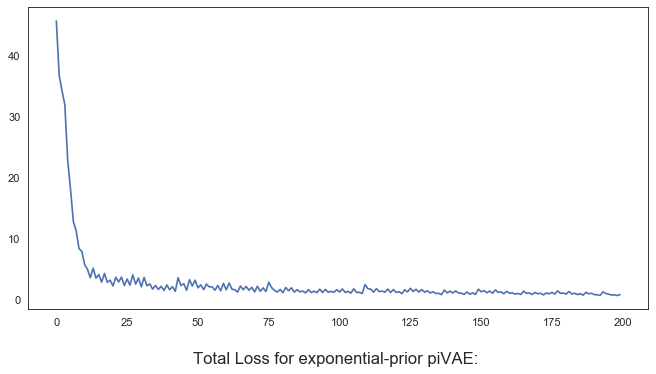

In [52]:
plt.plot(Loss_per_epoch_append)
plt.title("Total Loss for exponential-prior piVAE: ",  fontsize=15, y=-0.2)
plt.show()

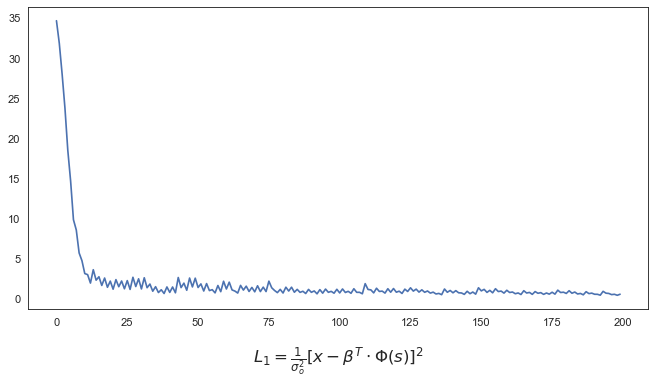

In [53]:
plt.plot(L1_per_epoch_append)
plt.title(r'$L_1=\frac{1}{\sigma^2_o}[x-\beta^T\cdot\Phi(s)]^2}$', fontsize=15, y=-0.2)
plt.show()

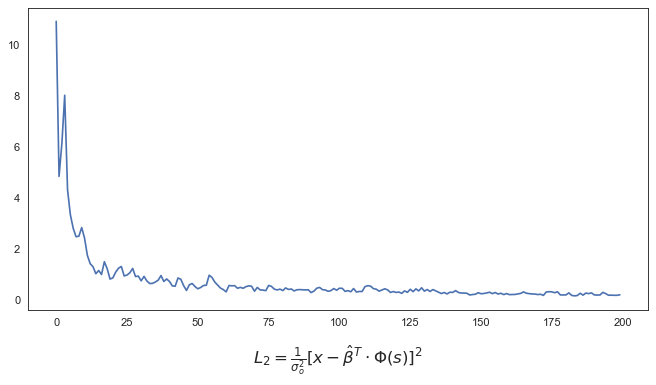

In [54]:
plt.plot(L2_per_epoch_append)
plt.title(r'$L_2=\frac{1}{\sigma^2_o}[x-\hat\beta^T\cdot\Phi(s)]^2}$', fontsize=15, y=-0.2)
plt.show()

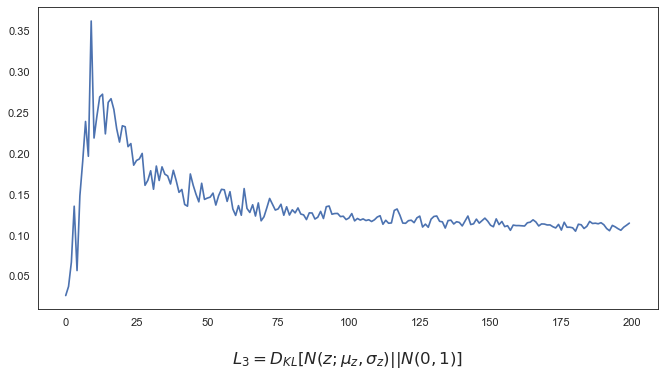

In [55]:
plt.plot(L3_per_epoch_append)
plt.title(r'$L_3=D_{KL}[N(z; \mu_z, \sigma_z)||N(0,1)]$', fontsize=15, y=-0.2)
plt.show()

### Generate Sine samples from piVAE using $z \sim N(0,1):$

In [28]:
num_piVAE_samples=5

In [29]:
test_pts_for_plot_tensor = torch.arange(-5., 5., 0.05).double() 
test_pts_for_plot_tensor.shape    

torch.Size([200])

In [30]:
test_pts_for_plot_np = np.arange(-5., 5., 0.05)
test_pts_for_plot_np.shape    

(200,)

In [31]:
piVAE_samples_tensor = pivae_model.generate_x_samples_from_pivae(
                                test_pts_for_plot_tensor.unsqueeze(1),5)

In [32]:
piVAE_samples_np = np.array(piVAE_samples_tensor.detach().numpy())

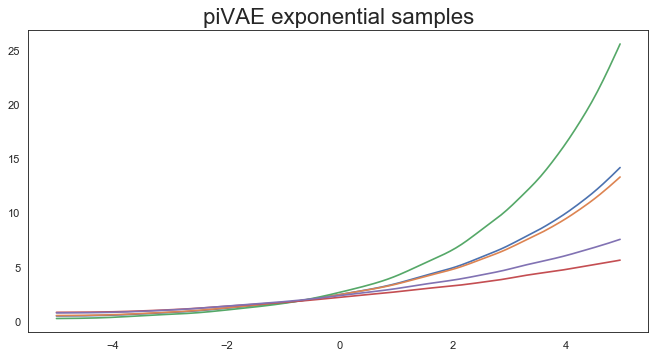

In [33]:
for i in range(piVAE_samples_np.shape[0]):
    plt.plot(test_pts_for_plot_tensor.detach().cpu().numpy(), piVAE_samples_np[i, :])
plt.title("piVAE exponential samples", fontsize=20)
plt.show()

In [34]:
def plot_decoded_x_samples_from_z_posterior(model, z_samples_from_post, s_star_tensor, x_star_tensor):    
            
    for i in range(z_samples_from_post.shape[0]):
        # Evaluates decoded x at location test_points when the value of the latent z_samples are given
        decoded_x = model.evaluate_decoded_Sine_at_given_z(z_samples_from_post[i,:],
                                                           test_pts_for_plot_tensor.unsqueeze(1))

        plt.plot(test_pts_for_plot_np, decoded_x.detach().numpy(), alpha=0.1, color='black')

    
    plt.scatter(s_star_tensor.detach().numpy(), x_star_tensor.detach().numpy(), s=1000, marker="+")
    plt.show()

In [35]:
# Compute a quantity proportional to p(z|x, s) where x and s are new test points
def get_unnormalized_log_posterior(model, s, x, z, obs_sigma):        
        
    #z ~ N(0,1)
    log_prior = -0.5 * torch.sum(z**2)

    phi_s = model.Phi(s)

    beta_hat = model.decoder(z)
    
    x_dec = torch.matmul(phi_s, beta_hat.squeeze()) 
    
    x=torch.squeeze(x)
    
    #GAUSSIAN LL 
    log_likelihoods = (-1 / (2 * obs_sigma**2)) * (x_dec - x)**2

    return log_prior + torch.sum(log_likelihoods)

In [36]:
def draw_MCMC_z_samples(model, nbr_z_samples, z_starting_point, MH_proposal_sigma, obs_sigma, s_star_tensor, x_star_tensor):
        
    z = z_starting_point
    #create a tensor of zeros to contain the z values that are going to be sampled
    z_samples = torch.zeros((nbr_z_samples, z_dim)).double()

    acceptance_prob_sum = 0

    for z_sample in range(nbr_z_samples):
        if(z_sample %1000==0):
            print("sample_id",z_sample)
            
        #z_p ~ N(z,MH_sigma**2)
        z_proposed = z + torch.randn_like(z) * MH_proposal_sigma**2            

        log_posterior_z = get_unnormalized_log_posterior(model, s_star_tensor, 
                                                         x_star_tensor, z, obs_sigma)

        log_posterior_z_proposed = get_unnormalized_log_posterior(model, s_star_tensor, 
                                                                x_star_tensor, z_proposed, obs_sigma)

        MH_ratio = torch.exp(log_posterior_z_proposed - log_posterior_z)

        acceptance_prob = torch.min(torch.tensor(1.0).double(), MH_ratio)

        u = torch.rand(1).double()

        if u < acceptance_prob:
            z = z_proposed

        z_samples[z_sample, :] = z

        acceptance_prob_sum += acceptance_prob.detach()

    print("mean acceptance prob", acceptance_prob_sum/nbr_z_samples)
    return z_samples


In [37]:
#A = np.random.uniform(1.0, 3.0)
#B = np.random.uniform(-2.0, 2.0)
#exp_s = A * np.exp(B * s)
        

A_grd_truth=1.5
B_grd_truth=1.

def ground_truth_exp_fct(locations):
    return A_grd_truth * np.exp(B_grd_truth*locations)

In [38]:
s_star_np=np.arange(-5.,5,0.01)
s_star_np.shape

(1000,)

In [39]:
x_star_np=ground_truth_exp_fct(s_star_np)
x_star_np.shape

(1000,)

In [40]:
#create a data frame with 2 columns: one for the s_star and one for the x_star
df=pd.DataFrame(s_star_np)
df['x_star']=x_star_np
df['s_star']=s_star_np
#df

In [41]:
#select observations from ground truth
nbr_obs=10
s_obs=np.zeros(nbr_obs)
x_obs=np.zeros(nbr_obs)

k=int(len(s_star_np)/nbr_obs)
print(k)
for i in range(nbr_obs):
    s_obs[i]=df['s_star'][k*i+70]
    x_obs[i]=df['x_star'][k*i+70]
s_obs.shape

100


(10,)

In [42]:
#add noise to ground truth
sigma_noise=2.
epsilon = np.random.normal(loc=0, scale=sigma_noise, size=len(x_obs))
epsilon.shape
y_obs=np.zeros(nbr_obs)
y_obs.shape
y_obs=x_obs +epsilon
y_obs.shape

(10,)

nbr observations: 10


Text(0.5, 1.0, 'Ground truth OU prior and 10 observations')

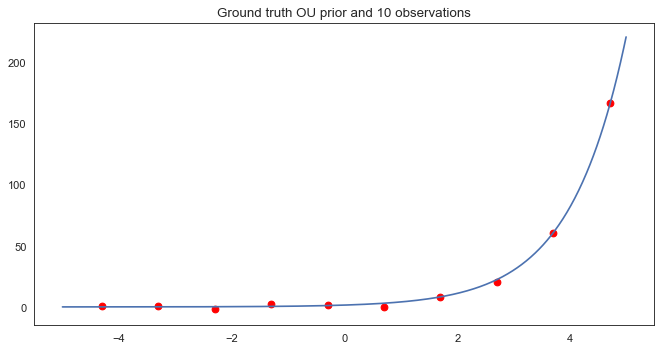

In [43]:
plt.plot(s_star_np, x_star_np, label='Ground truth')
plt.scatter(s_obs, y_obs, color='r')
print("nbr observations:", len(y_obs))
length=len(y_obs)
plt.title('Ground truth OU prior and 10 observations')
#plt.show()

In [44]:
z = torch.ones((z_dim,)).double()

#when MH_proposal_sigma increases the credible interval gets too narrow 
#when obs_sigma decreases: the mean posterior gets closer to the ground truth

nbr_iter=10000
MH_proposal_sigma=0.1
obs_sigma=0.1

mcmc_samples = draw_MCMC_z_samples(pivae_model, nbr_iter, z, MH_proposal_sigma, obs_sigma, torch.tensor(s_obs).unsqueeze(1), 
                                        torch.tensor(y_obs))

sample_id 0
sample_id 1000
sample_id 2000
sample_id 3000
sample_id 4000
sample_id 5000
sample_id 6000
sample_id 7000
sample_id 8000
sample_id 9000
mean acceptance prob tensor(0.4985, dtype=torch.float64)


In [46]:
mcmc_selected_samples_run1 = mcmc_samples[1000::100,:]

In [47]:
mcmc_selected_samples_run1.shape

torch.Size([90, 25])

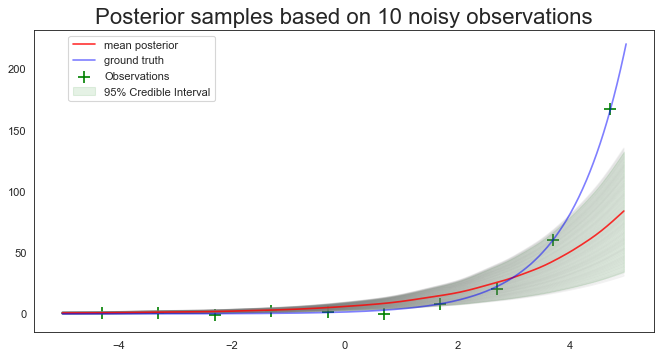

In [51]:
all_dec_x=[]    
for i in range(len(mcmc_selected_samples_run1)):
        
    decoded_x = pivae_model.evaluate_decoded_x_at_given_z(mcmc_selected_samples_run1[i,:], 
                                                             test_pts_for_plot_tensor.unsqueeze(1))
    
    plt.plot(test_pts_for_plot_np, decoded_x.detach().numpy(), alpha=0.1, color='grey')
    
    all_dec_x.append(decoded_x.detach().numpy())  
      
mean_dec_x=np.mean(np.array(all_dec_x), axis=0)

quantile_0975_dec_x=np.quantile(np.array(all_dec_x),0.975,axis=0)

quantile_0025_dec_x=np.quantile(np.array(all_dec_x),0.025,axis=0)
    
plt.plot(test_pts_for_plot_np, mean_dec_x, alpha=0.8, color='r', label='mean posterior')
    
plt.scatter(s_obs, y_obs, color="g", s=100, marker="+", label="Observations")
plt.plot(s_star_np, x_star_np, alpha=0.5, color='b', label="ground truth")

plt.fill_between(test_pts_for_plot_np, quantile_0025_dec_x, quantile_0975_dec_x,
                    facecolor="green",
                    color='green', 
                    alpha=0.1, label = '95% Credible Interval') 

plt.legend(bbox_to_anchor=(0.3, 1.))
plt.title("Posterior samples based on 10 noisy observations", fontsize=20)
plt.show()

In [56]:
#from the same function that generated 20 observation points, get new points 
#see the value of both Pi-VAE and Gp posterior. 
#Compute them against known function and report the RMSE. 

In [57]:
#select 20 new points from the dataframe
nbr_new_star=5
s_obs_new=np.zeros(nbr_new_star)
x_obs_new=np.zeros(nbr_new_star)
for i in range(nbr_new_star):
    s_obs_new[i]=df['s_star'][100*i]
    x_obs_new[i]=df['x_star'][100*i]
x_obs_new.shape

(5,)

Text(0.5, 1.0, 'Ground truth OU prior')

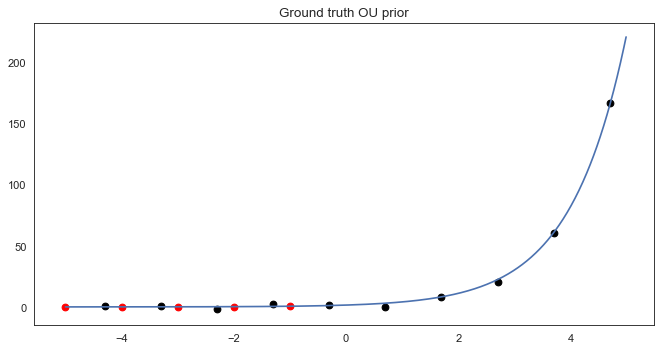

In [58]:
plt.plot(s_star_np, x_star_np, label='Ground truth')
plt.scatter(s_obs, y_obs, color='k')
plt.scatter(s_obs_new, x_obs_new,color="r")
#plt.scatter(s_star_np, y_obs, color='r', label='Noisy Observations')

#plt.legend(loc='upper left', borderaxespad=0.)
plt.title('Ground truth OU prior')
#plt.show()

In [59]:
#now we need to compute the posterior at these 20 new points
#the way to do this is to run MCMC on these samples and take the mean posterior of these samples
nbr_iter_2=10000
z = torch.ones((z_dim,)).double()

mcmc_samples2 = draw_MCMC_z_samples(pivae_model, nbr_iter_2, z, MH_proposal_sigma, obs_sigma, 
                                   torch.tensor(s_obs_new).unsqueeze(1), torch.tensor(x_obs_new))

sample_id 0
sample_id 1000
sample_id 2000
sample_id 3000
sample_id 4000
sample_id 5000
sample_id 6000
sample_id 7000
sample_id 8000
sample_id 9000
mean acceptance prob tensor(0.9456, dtype=torch.float64)


In [60]:
mcmc_selected_samples_run2 = mcmc_samples2[1000::100,:]

In [61]:
mcmc_selected_samples_run2.shape

torch.Size([90, 25])

In [62]:
def eval_decoded_x_at_given_z(model, z, s):        
        phi_s = model.Phi(s)       
        beta_hat = model.decoder(z)        
        x_dec = torch.matmul(phi_s, beta_hat)        
        return x_dec   

In [63]:
all_dec_x=[]    
for i in range(len(mcmc_selected_samples_run2)):
    decoded_new_x = eval_decoded_x_at_given_z(pivae_model, mcmc_selected_samples_run2[i,:], 
                                                             torch.tensor(s_obs_new).unsqueeze(1))

    all_dec_x.append(decoded_new_x.detach().numpy())  
      
new_star_mean_post=np.mean(np.array(all_dec_x), axis=0)
new_star_mean_post.shape

(5,)

In [64]:
#nbr_new_star=5
RMSE=np.sqrt(np.sum((new_star_mean_post - x_obs_new)**2/nbr_new_star))
RMSE

0.6583821255526657

In [ ]:
def check_beta(model, id):
    
    test_points = torch.arange(-5, 5, 0.1).reshape(100, 1)
    
    phi_s = model.Phi(test_points)
    
    beta = model.betas[id, :]
    
    x_encs = torch.matmul(phi_s, beta)
    
    z_mean, z_std = model.encoder(beta.unsqueeze(0))
    
    beta_hat = model.decoder(z_mean)
    
    x_decs = torch.matmul(beta_hat, torch.transpose(phi_s, 0, 1))
    
    #plot encoded x's against test locations
    plt.plot(test_points.detach().cpu().numpy(), x_encs.detach().cpu().numpy(), color='red')
    
    #plot decoded x's against test locations
    plt.plot(test_points.detach().cpu().numpy().reshape(100), x_decs.detach().cpu().numpy().reshape(100), color='green')
    
    plt.scatter(dataset_exp_s[id].reshape(K), dataset_exp_x[id].reshape(K))
    plt.title("Reconstruction of training data")
    plt.show()

In [ ]:
# ------ Check reconstructions of training data -------
for i in range(2):
    check_beta(pivae_model, i)

#%%